# Riding the Volatility Wave
Author: Diego Recht





## Introduction

Cryptocurrencies represent an entirely new market of traded securities. The current market capitalization is valued far past $600 billion dollars and continues to increase incrementally every day. 

One of the largest and most frequently traded coins is Bitcoin, BTC. The current value of BTC doubles that of Goldman Sachs, or even Bitcoin itself, one month earlier. Whether cryptocurrencies represent a bubble or a new disruptive emerging technology, it is undeniably a very lucrative and volatile investment opportunity.

This algorithm aims to take advantage of the present volatility in the cryptocurrency market by implementing Statistical Process Controls and prior economic knowledge to indicate when current market conditions warrant a purchase of coins. 

For simplicity and practicality of this project, I have limited the scope of my research to Bitcoin for two reasons: The amount of information readily available and the liquidity of the market.

## Data Sources

I was able to downloaded a free csv file from bitfinex.com cointaining all the executed trades from the bitfinex exchange throughout a 24hr time period.

This csv file contains over several hundred thousand trades, all spanning from midnight one day to midnight the following day. Once imported into excel the respective file can be manipulated with the following code and read into a python enviroment.

The csv file has main columns of information: The volume traded, whether it was a buy or sell, the price at which the trade occured, and the timestamp.

In order to determine what the net volume traded in a period is, the buy/sell column must be correlated with the amount traded in order to account for buy(positive),sell(negative) trades. To do this I assinged each trade with a 'sell' indicator as a negative amount. This allows me to compute a net amount signed and regress it directly to the percent change in price over the same time horizon.

The main focus is to develop a working knowledge of how price changes with respect to the net volume traded by analyzing the relationship between the two respective attributes and then utilizing statistical process controls to monitor the coin's process.

From this we can develop a "buy-trigger" given the specified rules of Statistical Process Control and Bitcoin's observable volatility.



In [ ]:
# Import all required packages
%matplotlib inline
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
plt.style.use('ggplot')

In [2]:
# Helper function to parse timestamp
def dateparse (time_in_secs):    
    return datetime.datetime.fromtimestamp(float(time_in_secs))

# Read trade volume data, and perform initial cleaning
trade_volume = pd.read_csv('Trades_New.csv', index_col=0, parse_dates=True,date_parser=dateparse) 
trade_volume = trade_volume.loc[:, ~trade_volume.columns.str.contains('^Unnamed')] 

# clean Unnamed columns
trade_volume['Amount_Signed'] = trade_volume['Amount'].where((trade_volume['Type'] == 'buy'), -trade_volume['Amount'])
del trade_volume['Amount']  
del trade_volume['Type']

# Read values data
values = pd.read_csv('Values_Charts.csv')
trade_volume.head()

,Price,Amount_Signed
Timestamp,,
2017-12-10 23:23:27,16091.00000,0.030159
2017-12-10 23:23:26,16072.60726,-0.005000
2017-12-10 23:23:26,16072.60726,-0.080000
2017-12-10 23:23:25,16071.00000,-0.100000
2017-12-10 23:23:25,16071.00000,-0.011344


In [3]:
# Function to perform regression analysis on average price v. net volume,
# Given the time time interval in mins, perform regression analysis
# Outputs the regression summary and chart

def generate_regression(interval):
    global trade_volume
    trade_volume_aggr = trade_volume.copy()
    trade_volume_aggr = trade_volume.groupby([pd.Grouper(freq=str(interval*60)+'s')]).sum()
    trade_volume_aggr['Price_Obs'] = trade_volume.groupby([pd.Grouper(freq=str(interval*60)+'s')]).mean()['Price']
    # print trade_volume_aggr[:10]
    trade_volume_aggr['Price_Change_Rate'] = trade_volume_aggr.pct_change()['Price_Obs']
    
    del trade_volume_aggr['Price']
    trade_volume_aggr.to_csv("Trade_Volume_%s_Mins_Interval.csv" % str(interval))
    
    reg_res = smf.ols('Price_Change_Rate ~ Amount_Signed', data=trade_volume_aggr).fit()
    print(reg_res.summary())
    coeff = reg_res.params['Amount_Signed']
    r2_adj = reg_res.rsquared_adj
    
    # Plot regression, but removing outlier first
    # Keep only the ones that are within +3 to -3 standard deviations
    trade_volume_aggr_no_outlier = trade_volume_aggr[np.abs(trade_volume_aggr['Price_Change_Rate']-trade_volume_aggr['Price_Change_Rate'].mean())<=(3*trade_volume_aggr['Price_Change_Rate'].std())] 
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.annotate(
        'Coeff: {:.8f}, '.format(coeff) + 'Adj R^2: {:.4f}'.format(r2_adj),
        xy=(.5, .9), 
        xycoords=ax.transAxes)
    sns.regplot(
        x='Amount_Signed', 
        y='Price_Change_Rate', 
        data=trade_volume_aggr_no_outlier
    ).set_title("Regression of Volume v. Price Change Rate - %s Mins Interval" % interval)

                            OLS Regression Results                            
Dep. Variable:      Price_Change_Rate   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.365
Method:                 Least Squares   F-statistic:                     327.0
Date:                Mon, 19 Feb 2018   Prob (F-statistic):           5.21e-58
Time:                        20:12:29   Log-Likelihood:                 2203.3
No. Observations:                 567   AIC:                            -4403.
Df Residuals:                     565   BIC:                            -4394.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0002      0.000      0.769

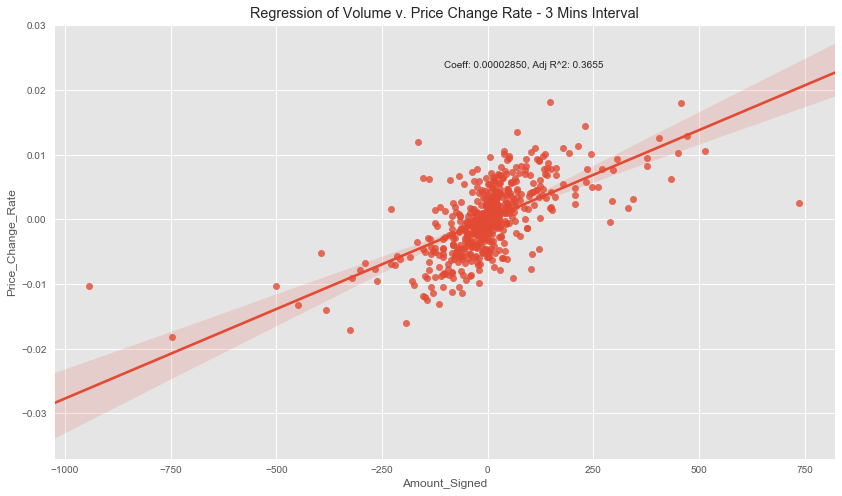

In [4]:
# Perform regression for min = 3
generate_regression(3)

                            OLS Regression Results                            
Dep. Variable:      Price_Change_Rate   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     262.6
Date:                Mon, 19 Feb 2018   Prob (F-statistic):           1.70e-40
Time:                        20:12:31   Log-Likelihood:                 881.39
No. Observations:                 244   AIC:                            -1759.
Df Residuals:                     242   BIC:                            -1752.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0004      0.000      0.834

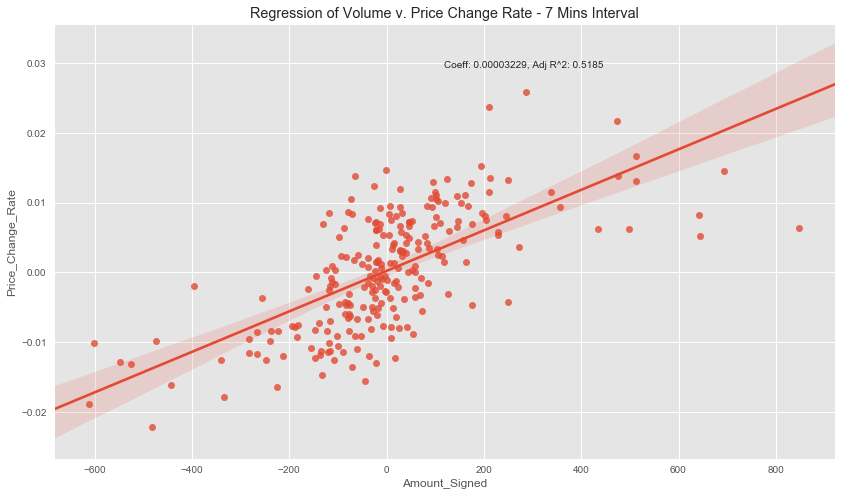

In [5]:
# Perform regression for min = 7
generate_regression(7)

                            OLS Regression Results                            
Dep. Variable:      Price_Change_Rate   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     178.4
Date:                Mon, 19 Feb 2018   Prob (F-statistic):           7.58e-25
Time:                        20:12:31   Log-Likelihood:                 383.22
No. Observations:                 113   AIC:                            -762.4
Df Residuals:                     111   BIC:                            -757.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0008      0.001      1.079

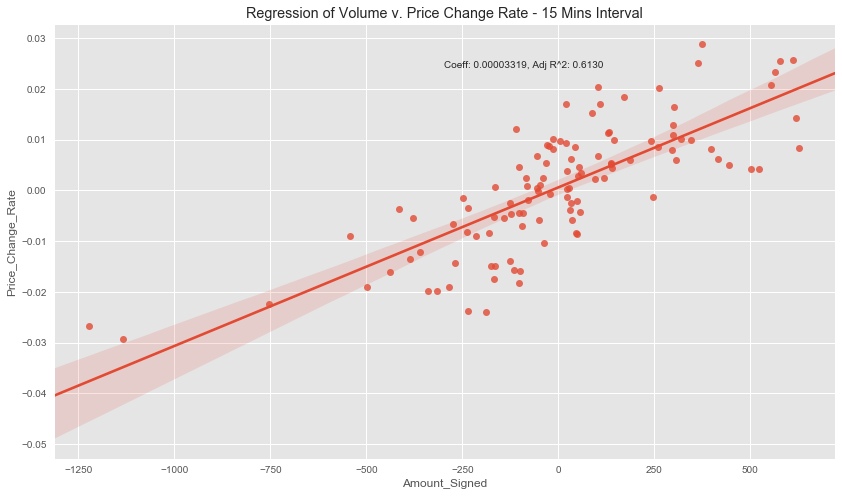

In [6]:
# Perform regression for min = 15
generate_regression(15)

                            OLS Regression Results                            
Dep. Variable:      Price_Change_Rate   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     91.71
Date:                Mon, 19 Feb 2018   Prob (F-statistic):           3.09e-13
Time:                        20:12:32   Log-Likelihood:                 179.26
No. Observations:                  56   AIC:                            -354.5
Df Residuals:                      54   BIC:                            -350.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0020      0.001      1.526

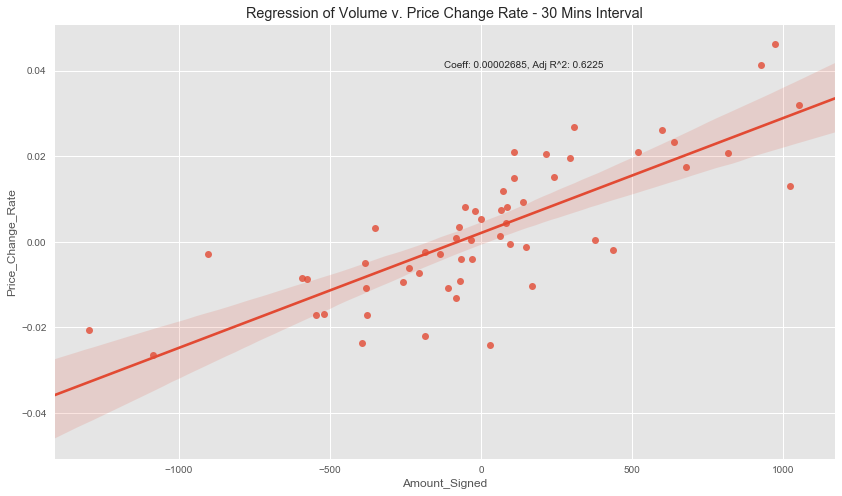

In [7]:
# Perform regression for min = 30
generate_regression(30)

                            OLS Regression Results                            
Dep. Variable:      Price_Change_Rate   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     95.82
Date:                Mon, 19 Feb 2018   Prob (F-statistic):           3.30e-10
Time:                        20:12:33   Log-Likelihood:                 85.984
No. Observations:                  28   AIC:                            -168.0
Df Residuals:                      26   BIC:                            -165.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0040      0.002      1.826

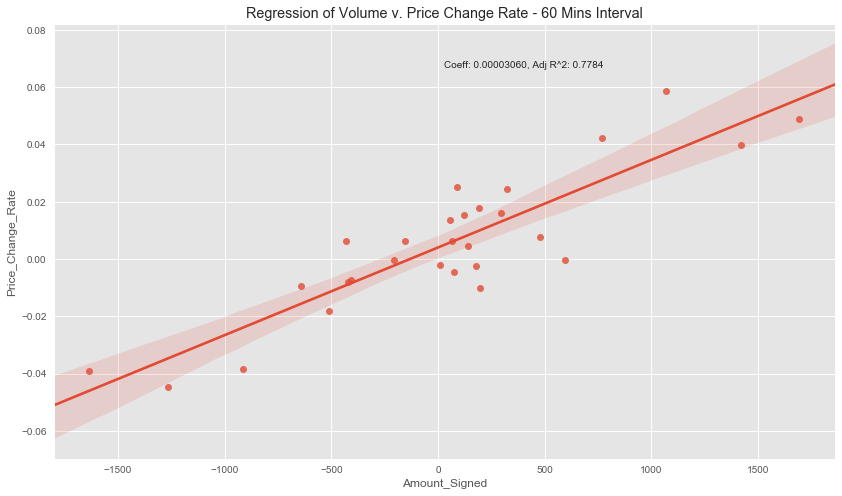

In [8]:
# Perform regression for min = 60
generate_regression(60)

                            OLS Regression Results                            
Dep. Variable:      Price_Change_Rate   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     73.09
Date:                Mon, 19 Feb 2018   Prob (F-statistic):           4.12e-08
Time:                        20:12:33   Log-Likelihood:                 65.548
No. Observations:                  22   AIC:                            -127.1
Df Residuals:                      20   BIC:                            -124.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0050      0.003      1.817

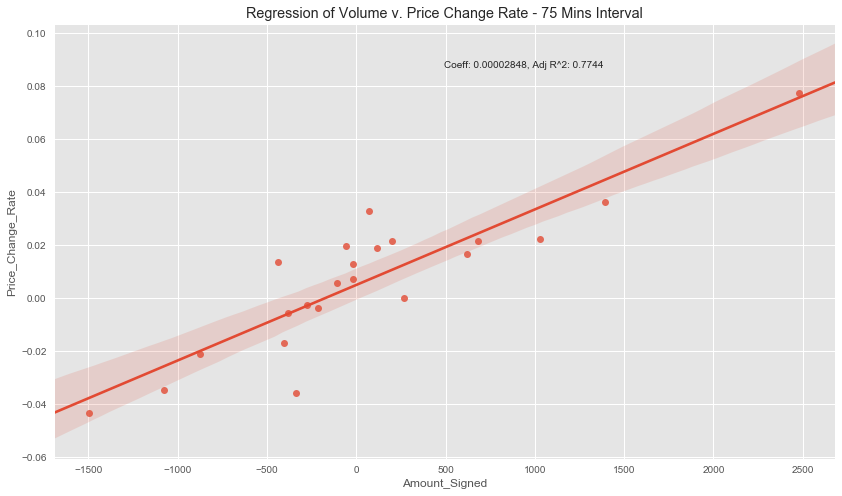

In [9]:
# Perform Regression for 3 hours
generate_regression(75)

### R Chart


The R chart meausres how much variation there is within each subgroup observation. If the variation within the subgroups is too high, tested by the run tests, then the measurements on the X-Bar chart are meanignless and the data is insignificant. However, since this is a trading program, any significant deviation on the R chart will consequently show up on the X chart as well, potentially breaking the run rules and indicating a buy trigger. 

If the measurements are in control then the observations are transferred to the X-Bar chart to check if the process is under control, if out of control, execute trades accordingly. Each subgroup is the aggregated average within a 1.5 minute time frame. Each R chart will yield 24 observations of 1.5 min, these will be later averaged and transferred to the X Chart for further process analyzation. 

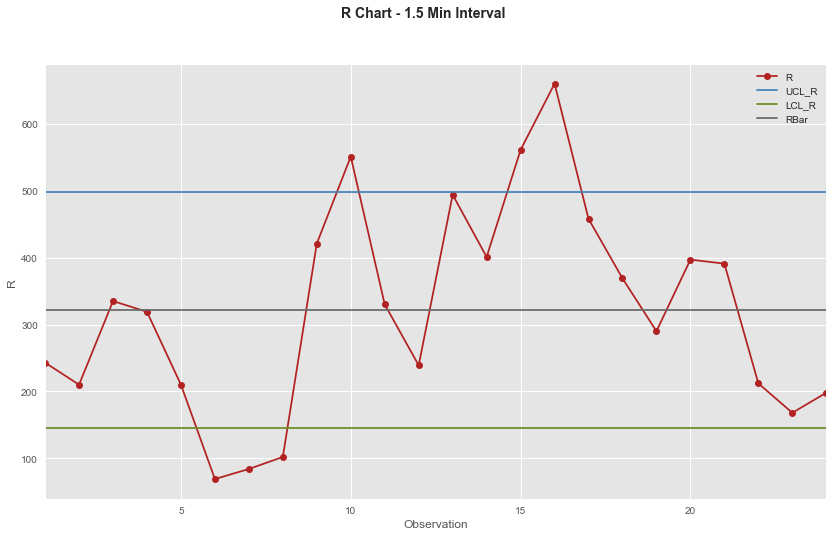

In [10]:
# Generate R Chart

r_chart = trade_volume.copy()
r_chart = trade_volume.groupby([pd.Grouper(freq='90s')]).mean()
r_chart['R'] = trade_volume.groupby([pd.Grouper(freq='90s')]).size()
r_chart = r_chart[['Price', 'R']][:24]

RBar = r_chart["R"].sum()/len(r_chart) ## mean value of range of each lot 
r_chart['RBar'] = RBar
r_chart['UCL_R'] = 1.548*RBar  # upper control limit
r_chart['LCL_R'] = 0.451*RBar  # lower control limit

r_chart['idx'] = range(1, len(r_chart) + 1)
r_chart.index = r_chart['idx']

del r_chart['idx']

r_chart.to_csv('r_chart.csv')

fig, ax = plt.subplots(figsize=(14, 8))
r_chart['R'].plot(marker="o", color='firebrick')
r_chart['UCL_R'].plot(color='steelblue')
r_chart['LCL_R'].plot(color='olivedrab')
r_chart['RBar'].plot(color='dimgray')
ax.legend()
ax.set_xlabel('Observation')
ax.set_ylabel('R')
fig.suptitle('R Chart - 1.5 Min Interval', fontsize=14, fontweight='bold')

### X Chart

The X Bar chart measures the mean of a process based on samples taken from equal time blocks, in this case every 36 minutes. The measurements of the samples for a given period create the subgroup and are then plotted on the graph. The mean and std from the sample data are used to construct upper and lower control limits such that, under the assumption that the variation follows a normal distribution, 99.73% of observations should fall between 3 and -3 sigma. When an observation is outside these established control limits, it indicates that the mean of the process is out-of-control and an assingable cause is determined to cause such variation. For Bitcoin, any assingable cause would be represented by large amounts of volume traded, hence influencing the change in price.

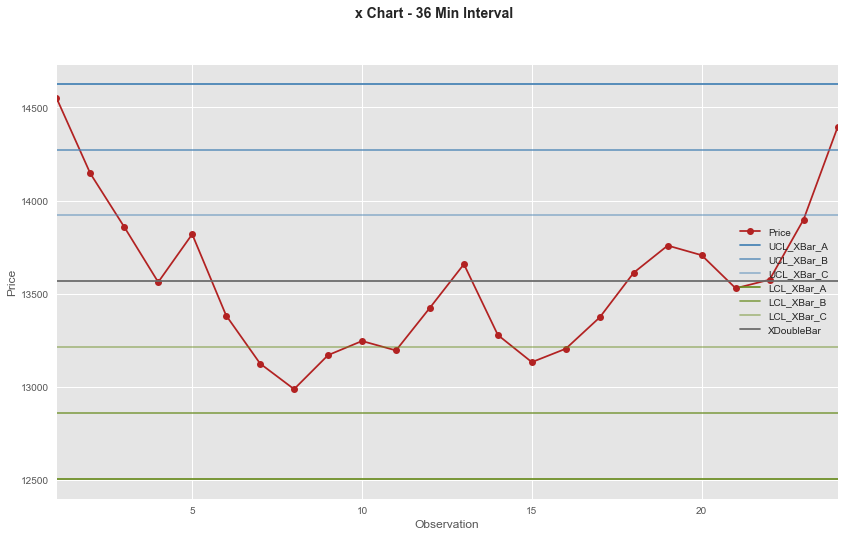

In [11]:
# Generate X Chart
x_chart = trade_volume.copy()
x_chart = trade_volume.groupby([pd.Grouper(freq='2160s')]).mean()  
x_chart['R'] = trade_volume.groupby([pd.Grouper(freq='2160s')]).size() 
x_chart = x_chart[['Price', 'R']][:24]
RBar = x_chart["R"].sum()/len(x_chart) ## mean value of range of each lot 
XDoubleBar = x_chart["Price"].sum()/len(x_chart)
x_chart['XDoubleBar'] = XDoubleBar
x_chart['UCL_XBar_A'] = XDoubleBar + (0.157 * RBar)
x_chart['UCL_XBar_B'] = XDoubleBar + (0.157 * RBar * 2/3)
x_chart['UCL_XBar_C'] = XDoubleBar + (0.157 * RBar * 1/3)
x_chart['LCL_XBar_A'] = XDoubleBar - (0.157 * RBar)
x_chart['LCL_XBar_B'] = XDoubleBar - (0.157 * RBar * 2/3)
x_chart['LCL_XBar_C'] = XDoubleBar - (0.157 * RBar * 1/3)

x_chart['idx'] = range(1, len(x_chart) + 1)
x_chart.index = x_chart['idx']

del x_chart['idx']

x_chart.to_csv('x_chart.csv')

fig, ax = plt.subplots(figsize=(14, 8))
x_chart['Price'].plot(marker="o", color='firebrick')
x_chart['UCL_XBar_A'].plot(color='steelblue', alpha=1)
x_chart['UCL_XBar_B'].plot(color='steelblue', alpha=0.75)
x_chart['UCL_XBar_C'].plot(color='steelblue', alpha=0.5)
x_chart['LCL_XBar_A'].plot(color='olivedrab', alpha=1)
x_chart['LCL_XBar_B'].plot(color='olivedrab', alpha=0.75)
x_chart['LCL_XBar_C'].plot(color='olivedrab', alpha=0.5)
x_chart['XDoubleBar'].plot(color='dimgray')

ax.legend()
ax.set_xlabel('Observation')
ax.set_ylabel('Price')

fig.suptitle('x Chart - 36 Min Interval', fontsize=14, fontweight='bold')

In [14]:
# from a given observations, decide if we should buy the stock or not
def is_buy(data_df):
    buy = False
    applied_rules = set()
    # prepare the data
    buy_data = data_df.copy()
    buy_data = trade_volume.groupby([pd.Grouper(freq='2160s')]).mean()  
    buy_data['R'] = data_df.groupby([pd.Grouper(freq='2160s')]).size() 
    buy_data = buy_data[['Price', 'R']][2:26]
    RBar = buy_data["R"].sum()/len(buy_data) 
    ## mean value of range of each lot 
    XDoubleBar = buy_data["Price"].sum()/len(buy_data)
    UCL_XBar = XDoubleBar + 0.157 * RBar
    LCL_XBar = XDoubleBar - 0.157 * RBar
    UCL_XBar_A = XDoubleBar + (0.157 * RBar)
    UCL_XBar_B = XDoubleBar + (0.157 * RBar * 2/3)
    UCL_XBar_C = XDoubleBar + (0.157 * RBar * 1/3)
    LCL_XBar_A = XDoubleBar - (0.157 * RBar)
    LCL_XBar_B = XDoubleBar - (0.157 * RBar * 2/3)
    LCL_XBar_C = XDoubleBar - (0.157 * RBar * 1/3)
    
    price_list = buy_data['Price'].tolist()
    
    buy_data['pct_chg'] = buy_data['Price'].pct_change()
    pct_chg = buy_data['pct_chg'].tolist()
    
    buy_data['prev'] = buy_data['pct_chg'].shift()
    
    # check all the rules applied
    # 1. One or more points beyond the control limits
    if (buy_data['Price'].any() < LCL_XBar):
        applied_rules.add('1')
        buy = True
        
    # 2. 2 out of 3 consecutive points in zone A or beyond (negative)
    for i, val in enumerate(price_list[:-2]):
        price_list_subset = price_list[i:i+3]
        price_list_a = [1 if x < LCL_XBar_B else 0 for x in price_list_subset]
        if sum(price_list_a) > 1:
            applied_rules.add('2')
            buy = True
            
    # 3. 4 out of 5 consecutive points in zone B or beyond (negative)
    for i, val in enumerate(price_list[:-4]):
        price_list_subset = price_list[i:i+5]
        price_list_b = [1 if x < LCL_XBar_C else 0 for x in price_list_subset]
        if sum(price_list_b) > 3:
            applied_rules.add('3')
            buy = True
            
    # 4. 7 or more consecutive points in zone C or beyond, at one side only (negative)
    for i, val in enumerate(price_list[:-7]):
        price_list_subset = price_list[i:i+8]
        price_list_low = [1 if x < 0 else 0 for x in price_list_subset]
        if sum(price_list_low) > 6:
            applied_rules.add('4')
            buy = True
            
    # 5. 7 consecutive points are in the same trend (negative)
    for i, val in enumerate(pct_chg[:-7]):
        pct_chg_subset = pct_chg[i:i+8]
        pct_chg_min = [1 if x < 0 else 0 for x in pct_chg_subset]
        if sum(pct_chg_min) > 6:
            applied_rules.add('5')
            buy = True
        
    # 6. 8 consecutive points with no point in zone C (negative)
    for i, val in enumerate(price_list[:-7]):
        price_list_subset = price_list[i:i+8]
        price_list_no_c = [1 if x < LCL_XBar_C else 0 for x in price_list_subset]
        if sum(price_list_no_c) > 7:
            applied_rules.add('6')
            buy = True
            
    # 7. 15 consecutive points in zone C
    for i, val in enumerate(price_list[:-14]):
        price_list_subset = price_list[i:i+15]
        price_list_c = [1 if x > LCL_XBar_C and x < UCL_XBar_C else 0 for x in price_list_subset]
        if sum(price_list_c) > 14:
            applied_rules.add('7')
            buy = True
            
    # 8. 14 consecutive points alternating up and down
    buy_data_subset = buy_data[2:].copy()
    buy_data_subset['mult_val'] =  buy_data_subset['pct_chg'] * buy_data_subset['prev']
    buy_data_subset['alt'] = buy_data_subset['mult_val'].apply(lambda x: 0 if x < 0 else 1)
    price_list_alt = buy_data_subset['alt'].tolist()
    for i, val in enumerate(price_list_alt[:-13]):
        price_list_subset = price_list[i:i+14]
        if sum(price_list_c) > 13:
            applied_rules.add('8')
            buy = True
    
    if (buy):
        print ("Action: Buy")   
        print ("Rules applied: %s" % ", ".join(applied_rules))

In [15]:
# test the rules for the data
is_buy(trade_volume)

Action: Buy
Rules applied: 3, 1
